#### Import Libraries

In [61]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

#### Load and preprare the data

In [76]:
# Load the dataset
file_path='C:/Users/Administrator/Documents/kifiya/Week_10/data/preproccessed_brent_oil_prices.csv'
data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

# Replace NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)  # Drop rows with NaN values
# Display the first few rows
display(data.head())

,Price,Returns,Log_Returns,Volatility,Momentum,Rolling_Corr
Date,,,,,,
1987-07-17,20.63,0.011275,0.011211,0.008180,0.90,0.562215
1987-07-20,20.55,-0.003878,-0.003885,0.008313,0.72,0.473972
1987-07-21,20.35,-0.009732,-0.009780,0.008812,0.47,0.364089
1987-07-22,20.33,-0.000983,-0.000983,0.008312,0.05,0.186857
1987-07-23,20.15,-0.008854,-0.008893,0.008378,-0.25,-0.070285


#### Check for stationarity

In [63]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] > 0.05  # Returns True if the series is non-stationary

# Check each series in the dataset
for column in data.columns:
    print(f'ADF Test for {column}:')
    if adf_test(data[column]):
        data[column] = data[column].diff().dropna()  # Differencing the series to make it stationary


ADF Test for Price:
ADF Statistic: -2.0024239231103413
p-value: 0.2855113057646391
ADF Test for Returns:
ADF Statistic: -17.089095838567484
p-value: 7.612822497372556e-30
ADF Test for Log_Returns:
ADF Statistic: -16.389473929373164
p-value: 2.702886571716074e-29
ADF Test for Volatility:
ADF Statistic: -9.607333282183975
p-value: 1.8510726021203636e-16
ADF Test for Momentum:
ADF Statistic: -12.791629712745005
p-value: 7.056641626298182e-24
ADF Test for Rolling_Corr:
ADF Statistic: -17.198449404650574
p-value: 6.483248971809378e-30


#### Split Data into Training and Test Sets

In [64]:
# Split data into training and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

#### Check for Multicollinearity

In [77]:
correlation_matrix = train.corr()
display(correlation_matrix)


,Price,Returns,Log_Returns,Volatility,Momentum,Rolling_Corr
Price,1.000000,0.812801,0.812652,-0.011133,0.448249,0.115554
Returns,0.812801,1.000000,0.999046,0.002016,0.360201,0.141352
Log_Returns,0.812652,0.999046,1.000000,-0.011433,0.361295,0.141171
Volatility,-0.011133,0.002016,-0.011433,1.000000,-0.042168,0.012876
Momentum,0.448249,0.360201,0.361295,-0.042168,1.000000,0.201448
Rolling_Corr,0.115554,0.141352,0.141171,0.012876,0.201448,1.000000


In [66]:
import pandas as pd

def validate_data_quality(df):
    missing_values = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    return {
        'missing_values': missing_values,
        'duplicates': duplicates
    }

def clean_data(df):
    # Replace inf values with NaN for reliable dropping
    df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
    
    # Drop rows with missing values
    df_cleaned = df.dropna(how='any')
    
    # Drop duplicate entries
    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned

# Validate data quality before cleaning
quality_checks = validate_data_quality(train)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])

# Clean the data
train_cleaned = clean_data(train)

# Validate data quality after cleaning
quality_checks_cleaned = validate_data_quality(train_cleaned)
print("\nData Quality Check Results After Cleaning:")
print("Missing Values:", quality_checks_cleaned['missing_values'])
print("Duplicate Entries:", quality_checks_cleaned['duplicates'])

display(train_cleaned.head())



Data Quality Check Results:
Missing Values: 1
Duplicate Entries: 0

Data Quality Check Results After Cleaning:
Missing Values: 0
Duplicate Entries: 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10300\463808054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)


,Price,Returns,Log_Returns,Volatility,Momentum,Rolling_Corr
Date,,,,,,
1987-07-20,-0.08,-0.003878,-0.003885,0.008313,0.72,0.473972
1987-07-21,-0.20,-0.009732,-0.009780,0.008812,0.47,0.364089
1987-07-22,-0.02,-0.000983,-0.000983,0.008312,0.05,0.186857
1987-07-23,-0.18,-0.008854,-0.008893,0.008378,-0.25,-0.070285
1987-07-24,-0.57,-0.028288,-0.028696,0.010824,-1.05,-0.597423


In [67]:
print(train.isnull().sum())
train = train.dropna()
print(train.isnull().sum().sum())  # Should output 0


Price           1
Returns         0
Log_Returns     0
Volatility      0
Momentum        0
Rolling_Corr    0
dtype: int64
0


#### Fit the VAR Model

In [68]:
# Step 3: Check for stationarity and difference if needed
train_pca_df = pd.DataFrame(train)
for col in train_pca_df.columns:
    result = adfuller(train_pca_df[col])
    if result[1] > 0.05:
        train_pca_df[col] = train_pca_df[col].diff().dropna()  # Difference if non-stationary
display(train_pca_df.head())

,Price,Returns,Log_Returns,Volatility,Momentum,Rolling_Corr
Date,,,,,,
1987-07-20,-0.08,-0.003878,-0.003885,0.008313,0.72,0.473972
1987-07-21,-0.20,-0.009732,-0.009780,0.008812,0.47,0.364089
1987-07-22,-0.02,-0.000983,-0.000983,0.008312,0.05,0.186857
1987-07-23,-0.18,-0.008854,-0.008893,0.008378,-0.25,-0.070285
1987-07-24,-0.57,-0.028288,-0.028696,0.010824,-1.05,-0.597423


In [69]:
# Save the original column names
column_names = train.columns

# Fit the VAR model
model = VAR(train)
try:
    lag_order = model.select_order(maxlags=3)  # Choose maxlags based on your data size
    optimal_lag = lag_order.aic
    var_model = model.fit(optimal_lag)

    # Access the fitted values (predicted values) and assign the original column names
    fitted_values = pd.DataFrame(var_model.fittedvalues, columns=column_names)

    # Similarly, for forecasted values, you can also convert the forecast to a DataFrame
    forecast = var_model.forecast(train.values[-optimal_lag:], steps=5)  # for example, a 5-step forecast
    forecast_df = pd.DataFrame(forecast, columns=column_names)

    print("Fitted Values:\n", fitted_values)
    print("Forecasted Values:\n", forecast_df)

except np.linalg.LinAlgError:
    print("Handling LinAlgError by refitting with a lower lag or regularization.")

Fitted Values:
                Price   Returns  Log_Returns  Volatility  Momentum  \
Date                                                                
1987-07-23  0.016980  0.000704     0.000683    0.008471 -0.120710   
1987-07-24  0.015197  0.000837     0.000819    0.008540 -0.341754   
1987-07-27 -0.052168 -0.001146    -0.001231    0.011089 -1.037177   
1987-07-28 -0.108413 -0.001248    -0.001287    0.010837 -1.294173   
1987-07-29 -0.006589  0.001378     0.001372    0.011975 -0.492082   
...              ...       ...          ...         ...       ...   
2015-10-23  0.018473  0.000633     0.000331    0.024296 -1.072033   
2015-10-26 -0.060885 -0.000540    -0.000789    0.023959 -1.731781   
2015-10-27  0.053406  0.001679     0.001393    0.023959 -0.458938   
2015-10-28 -0.043069 -0.000731    -0.001071    0.023937 -1.226715   
2015-10-29  0.102999  0.001463     0.001167    0.024646  1.201354   

            Rolling_Corr  
Date                      
1987-07-23      0.158402  
1987-

c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


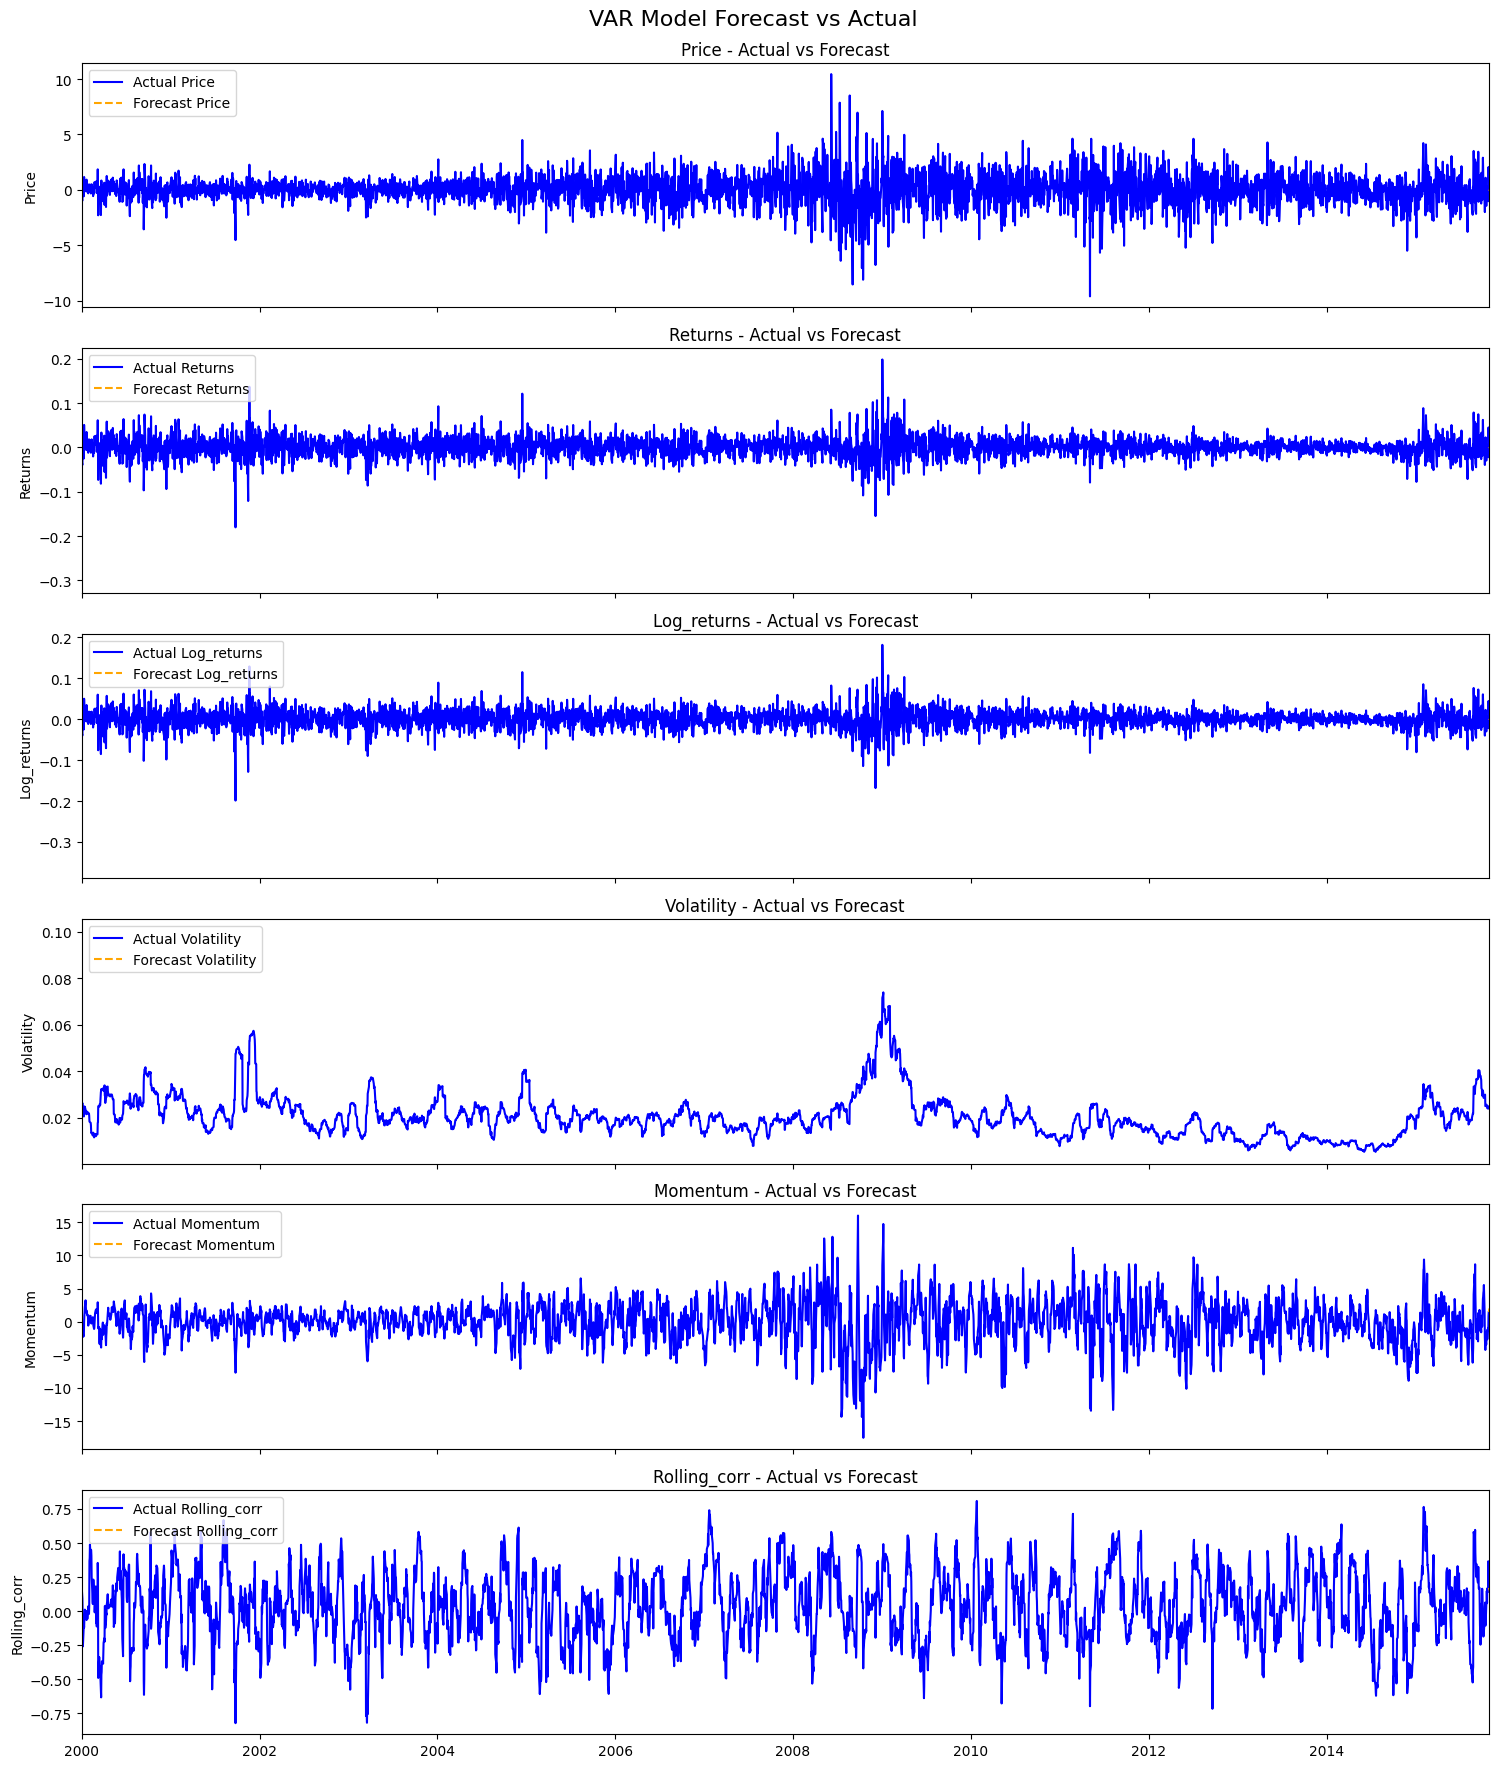

In [71]:
train_data = train

variables = train_data.columns  # ['price', 'returns', 'log_returns', 'volatility', 'Momentum']
num_vars = len(variables)

fig, axes = plt.subplots(num_vars, 1, figsize=(15, num_vars * 3), sharex=True)

for i, var in enumerate(variables):
    # Plot actual values
    axes[i].plot(train_data.index, train_data[var], label=f'Actual {var.capitalize()}', color='blue')
    
    # Plot forecasted values (shifted to match the forecast period)
    forecast_index = pd.date_range(start=train_data.index[-1], periods=len(forecast_df)+1, freq='B')[1:]  # Assuming business day frequency
    axes[i].plot(forecast_index, forecast_df[var], label=f'Forecast {var.capitalize()}', linestyle='--', color='orange')

    # Add legend and labels
    axes[i].legend(loc='upper left')
    axes[i].set_title(f'{var.capitalize()} - Actual vs Forecast')
    axes[i].set_ylabel(var.capitalize())

# Set a limit for the x-axis if needed to zoom in on recent data
axes[-1].set_xlim(pd.Timestamp('2000-01-01'), train_data.index[-1])

# Improve spacing and layout
fig.tight_layout()
fig.suptitle("VAR Model Forecast vs Actual", fontsize=16)
fig.subplots_adjust(top=0.95)  # Adjust to fit the suptitle

# Show the plot
plt.show()


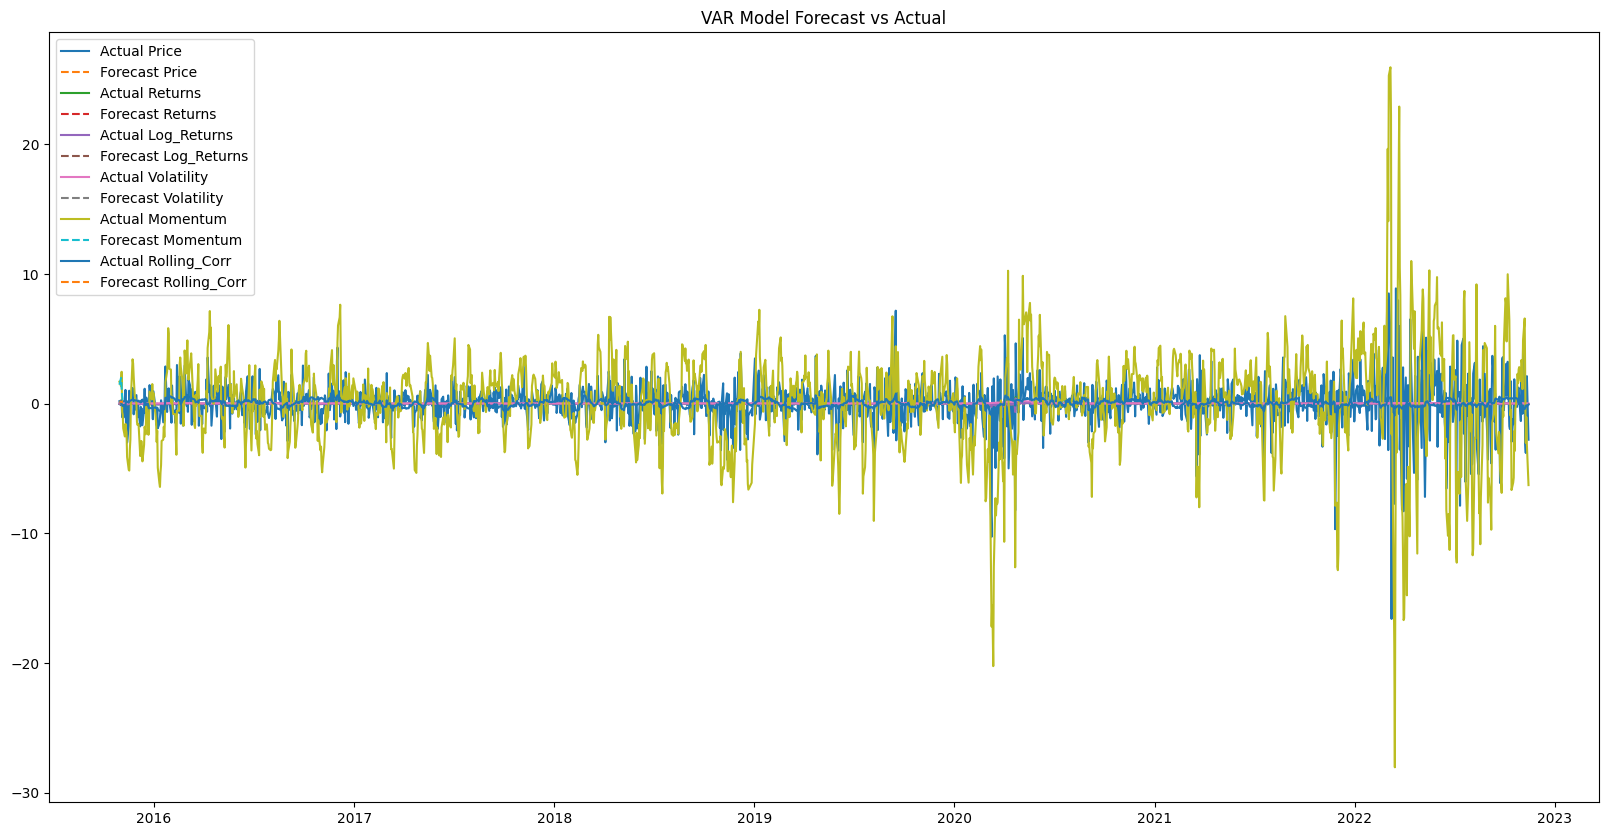

In [72]:
# Plotting actual vs predicted values for model evaluation
def plot_forecast_vs_actual(train, test, forecast_df):
    plt.figure(figsize=(20, 10))
    for col in test.columns:
        plt.plot(test.index, test[col], label=f'Actual {col}')
        forecast_index = pd.date_range(start=train.index[-1], periods=len(forecast_df)+1, freq='B')[1:]
        plt.plot(forecast_index, forecast_df[col], label=f'Forecast {col}', linestyle='--')
    plt.legend()
    plt.title("VAR Model Forecast vs Actual")
    plt.show()
# Plotting and evaluating
plot_forecast_vs_actual(train, test, forecast_df)


#### Evaluate the Model

In [73]:
# Model evaluation function with extended metrics
def evaluate_model(test, forecast_df, recency_window=5):
    evaluation_metrics = {}

    for col in test.columns:
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(test[col].iloc[:len(forecast_df)], forecast_df[col]))
        
        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Recency RMSE (last 'recency_window' points)
        recent_rmse = np.sqrt(mean_squared_error(test[col].iloc[-recency_window:], forecast_df[col].iloc[-recency_window:]))

        evaluation_metrics[col] = {
            'Root Mean Squared Error ': rmse,
            'Mean Absolute Error ': mae,
            'Mean Absolute Percentage Error': mape,
            'Recency RMSE': recent_rmse
        }
        
        # Print the metrics
        print(f"Metrics for {col}:")
        print(f"  Root Mean Squared Error: {rmse}")
        print(f"  Mean Absolute Error: {mae}")
        print(f"  Mean Absolute Percentage Error: {mape}")
        print(f"  Recency RMSE (last {recency_window} values): {recent_rmse}\n")
        
    return evaluation_metrics

rmses = evaluate_model(test, forecast_df)

Metrics for Price:
  Root Mean Squared Error: 0.48042199134825664
  Mean Absolute Error: 0.29004348311529915
  Mean Absolute Percentage Error: 0.9634961498609197
  Recency RMSE (last 5 values): 2.719885561870192

Metrics for Returns:
  Root Mean Squared Error: 0.010029261022105714
  Mean Absolute Error: 0.006346205909345881
  Mean Absolute Percentage Error: 1.2678118604435733
  Recency RMSE (last 5 values): 0.02844635192911252

Metrics for Log_Returns:
  Root Mean Squared Error: 0.010000346804992306
  Mean Absolute Error: 0.006290890856990127
  Mean Absolute Percentage Error: 1.1757368467948244
  Recency RMSE (last 5 values): 0.02860718947683506

Metrics for Volatility:
  Root Mean Squared Error: 0.004436968673667334
  Mean Absolute Error: 0.003492467568186565
  Mean Absolute Percentage Error: 0.18407299836202573
  Recency RMSE (last 5 values): 0.005032282886948314

Metrics for Momentum:
  Root Mean Squared Error: 0.9812595406219995
  Mean Absolute Error: 0.8978269364123198
  Mean Abso

In [74]:
# Saving the model
def save_model(var_model, model_path='C:/Users/Administrator/Documents/kifiya/Week_10/Models/var_model.joblib'):
    joblib.dump(var_model, model_path)
    print(f"Model saved to {model_path}")

# Save the model
save_model(var_model)

Model saved to C:/Users/Administrator/Documents/kifiya/Week_10/Models/var_model.joblib
